In [1]:
# Install required packages
!pip install -q ultralytics opencv-python-headless matplotlib gradio pillow numpy
!pip install -q segment-anything git+https://github.com/facebookresearch/segment-anything.git

# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import gradio as gr
import time
import torch
from pathlib import Path
import urllib.request
from typing import Tuple, List, Optional, Dict
import io
import base64
import os
from glob import glob

# Check GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'Not available'}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Using device: cuda
GPU: Tesla T4


In [2]:
# Create directory for test images
!mkdir -p test_images

# Download diverse test images
test_image_urls = {
    "easy_portrait": "https://images.unsplash.com/photo-1494790108377-be9c29b29330?w=800",
    "complex_hair": "https://images.unsplash.com/photo-1534528741775-53994a69daeb?w=800",
    "multiple_objects": "https://images.unsplash.com/photo-1610832958506-aa56368176cf?w=800",
    "transparent_glass": "https://images.unsplash.com/photo-1584305574647-0cc949a2bb9f?w=800",
}

print("Downloading test images...")
for name, url in test_image_urls.items():
    try:
        urllib.request.urlretrieve(url, f"test_images/{name}.jpg")
        print(f"Downloaded: {name}")
    except Exception as e:
        print(f"Failed to download {name}: {e}")

Downloaded: easy_portrait
Downloaded: complex_hair
Downloaded: multiple_objects
Downloaded: transparent_glass


In [3]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# Download SAM checkpoint
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P ./

# Initialize SAM model
print("Loading SAM model...")
model_load_start = time.time()

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# Create predictors
mask_generator = SamAutomaticMaskGenerator(sam)
predictor = SamPredictor(sam)

model_load_time = time.time() - model_load_start
print(f"Model loaded in {model_load_time:.2f} seconds")

Loading SAM model...
Model loaded in 8.32 seconds


In [4]:
class BackgroundRemover:
    def remove_background(image: np.ndarray, mask: np.ndarray,
                         background_color: Tuple[int, int, int] = (255, 255, 255),
                         blur_background: bool = False) -> np.ndarray:
        if len(mask.shape) == 3:
            mask = mask[0]

        result = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)
        result[mask] = np.concatenate([image[mask], 255 * np.ones((np.sum(mask), 1))], axis=1).astype(np.uint8)

        if not blur_background:
            result[~mask] = [*background_color, 0]
        else:
            blurred_bg = cv2.GaussianBlur(image, (51, 51), 0)
            result[~mask] = np.concatenate([blurred_bg[~mask], 150 * np.ones((np.sum(~mask), 1))], axis=1).astype(np.uint8)

        return result

class BatchProcessor:
    def __init__(self, segmenter):
        self.segmenter = segmenter

    def process_batch(self, image_paths: List[str], output_dir: str = "batch_results"):
        import os
        os.makedirs(output_dir, exist_ok=True)

        results = []
        total_time = 0

        print(f"Processing {len(image_paths)} images...")

        for i, image_path in enumerate(image_paths):
            try:
                print(f"  [{i+1}/{len(image_paths)}] Processing: {os.path.basename(image_path)}")

                img = cv2.imread(image_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                vis, masks, stats = self.segmenter.segment_automatic(img)
                total_time += stats['inference_time']

                base_name = os.path.splitext(os.path.basename(image_path))[0]
                vis_path = os.path.join(output_dir, f"{base_name}_segmented.png")
                plt.imsave(vis_path, vis)

                if len(masks) > 0:
                    largest_mask = max(masks, key=lambda x: x['area'])
                    bg_removed = BackgroundRemover.remove_background(img, largest_mask['segmentation'])
                    bg_path = os.path.join(output_dir, f"{base_name}_nobg.png")
                    plt.imsave(bg_path, bg_removed)

                results.append({
                    'image': image_path,
                    'masks_found': len(masks),
                    'inference_time': stats['inference_time'],
                    'output_path': vis_path
                })

                print(f"     Found {len(masks)} objects in {stats['inference_time']:.3f}s")

            except Exception as e:
                print(f"     Failed: {e}")
                results.append({
                    'image': image_path,
                    'error': str(e),
                    'masks_found': 0
                })

        print(f"Batch Processing Summary:")
        print(f"   Total images: {len(image_paths)}")
        print(f"   Successful: {len([r for r in results if 'error' not in r])}")
        print(f"   Total time: {total_time:.3f}s")
        print(f"   Average time per image: {total_time/len(image_paths):.3f}s")
        print(f"   Results saved to: {output_dir}/")

        return results

In [5]:
class SAMSegmenter:
    def __init__(self, sam_model, device):
        self.sam = sam_model
        self.device = device
        self.mask_generator = SamAutomaticMaskGenerator(sam_model)
        self.predictor = SamPredictor(sam_model)

    def segment_automatic(self, image: np.ndarray) -> Tuple[np.ndarray, dict, float]:
        start_time = time.time()
        masks = self.mask_generator.generate(image)
        inference_time = time.time() - start_time

        vis = self._visualize_masks(image, masks)

        stats = {
            'num_objects': len(masks),
            'inference_time': inference_time,
            'image_size': image.shape[:2]
        }

        return vis, masks, stats

    def segment_with_points(self, image: np.ndarray, points: List[Tuple[int, int]],
                           labels: List[int]) -> Tuple[np.ndarray, np.ndarray, float]:
        start_time = time.time()

        self.predictor.set_image(image)
        points_array = np.array(points)
        labels_array = np.array(labels)

        masks, scores, logits = self.predictor.predict(
            point_coords=points_array,
            point_labels=labels_array,
            multimask_output=True,
        )

        inference_time = time.time() - start_time
        best_mask = masks[np.argmax(scores)]
        vis = self._visualize_single_mask(image, best_mask, points, labels)

        return vis, best_mask, inference_time

    def segment_with_box(self, image: np.ndarray, box: Tuple[int, int, int, int]) -> Tuple[np.ndarray, np.ndarray, float]:
        start_time = time.time()

        self.predictor.set_image(image)
        box_array = np.array(box)
        masks, scores, logits = self.predictor.predict(
            box=box_array,
            multimask_output=False,
        )

        inference_time = time.time() - start_time
        mask = masks[0]
        vis = self._visualize_box_mask(image, mask, box)

        return vis, mask, inference_time

    def _visualize_masks(self, image: np.ndarray, masks: List[dict]) -> np.ndarray:
        plt.figure(figsize=(12, 8))
        plt.imshow(image)

        if len(masks) == 0:
            return image

        sorted_masks = sorted(masks, key=(lambda x: x['area']), reverse=True)
        overlay = np.zeros((*image.shape[:2], 4))

        for i, mask in enumerate(sorted_masks):
            m = mask['segmentation']
            color = np.concatenate([np.random.random(3), [0.5]])
            overlay[m] = color

        plt.imshow(overlay)
        plt.axis('off')
        plt.title(f'Automatic Segmentation - {len(masks)} objects detected')
        plt.tight_layout()

        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', dpi=150)
        buf.seek(0)
        vis = np.array(Image.open(buf))
        plt.close()

        return vis

    def _visualize_single_mask(self, image: np.ndarray, mask: np.ndarray,
                               points: List, labels: List) -> np.ndarray:
        plt.figure(figsize=(10, 10))
        plt.imshow(image)

        color_mask = np.zeros((*mask.shape, 4))
        color_mask[mask] = [0, 1, 0, 0.6]
        plt.imshow(color_mask)

        points = np.array(points)
        labels = np.array(labels)

        pos_points = points[labels == 1]
        neg_points = points[labels == 0]

        plt.scatter(pos_points[:, 0], pos_points[:, 1], c='green', s=200,
                   marker='*', edgecolors='white', linewidths=2, label='Foreground')
        if len(neg_points) > 0:
            plt.scatter(neg_points[:, 0], neg_points[:, 1], c='red', s=200,
                       marker='X', edgecolors='white', linewidths=2, label='Background')

        plt.legend()
        plt.axis('off')
        plt.title('Point-based Segmentation')
        plt.tight_layout()

        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', dpi=150)
        buf.seek(0)
        vis = np.array(Image.open(buf))
        plt.close()

        return vis

    def _visualize_box_mask(self, image: np.ndarray, mask: np.ndarray,
                           box: Tuple) -> np.ndarray:
        plt.figure(figsize=(10, 10))
        plt.imshow(image)

        color_mask = np.zeros((*mask.shape, 4))
        color_mask[mask] = [0, 0.5, 1, 0.6]
        plt.imshow(color_mask)

        x1, y1, x2, y2 = box
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                            fill=False, edgecolor='yellow', linewidth=3)
        plt.gca().add_patch(rect)

        plt.axis('off')
        plt.title('Box-based Segmentation')
        plt.tight_layout()

        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', dpi=150)
        buf.seek(0)
        vis = np.array(Image.open(buf))
        plt.close()

        return vis

# Initialize segmenter and batch processor
segmenter = SAMSegmenter(sam, device)
batch_processor = BatchProcessor(segmenter)
print("Segmenter and batch processor initialized")

Segmenter and batch processor initialized


In [6]:
def process_image_with_bg_removal(image, mode, point_x=None, point_y=None, box_coords=None, bg_mode="transparent"):
    if image is None:
        return None, "Please upload an image", "", None

    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    elif image.shape[2] == 4:
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)

    try:
        if mode == "Automatic - Segment Everything":
            vis, masks, stats = segmenter.segment_automatic(image)
            info = f"Detected {stats['num_objects']} objects. Time: {stats['inference_time']:.3f}s"

            bg_removed = None
            if len(masks) > 0:
                largest_mask = max(masks, key=lambda x: x['area'])
                if bg_mode == "transparent":
                    bg_removed = BackgroundRemover.remove_background(image, largest_mask['segmentation'])
                elif bg_mode == "white":
                    bg_removed = BackgroundRemover.remove_background(image, largest_mask['segmentation'], (255, 255, 255))
                elif bg_mode == "blur":
                    bg_removed = BackgroundRemover.remove_background(image, largest_mask['segmentation'], blur_background=True)

            return vis, info, f"Inference: {stats['inference_time']:.3f}s", bg_removed

        elif mode == "Point - Click to Segment":
            if point_x is None or point_y is None:
                return image, "Please provide point coordinates", "", None

            points = [(int(point_x), int(point_y))]
            labels = [1]

            vis, mask, time_taken = segmenter.segment_with_points(image, points, labels)
            info = f"Segmented object at point ({point_x}, {point_y}). Time: {time_taken:.3f}s"

            bg_removed = None
            if bg_mode == "transparent":
                bg_removed = BackgroundRemover.remove_background(image, mask)
            elif bg_mode == "white":
                bg_removed = BackgroundRemover.remove_background(image, mask, (255, 255, 255))
            elif bg_mode == "blur":
                bg_removed = BackgroundRemover.remove_background(image, mask, blur_background=True)

            return vis, info, f"Inference: {time_taken:.3f}s", bg_removed

        elif mode == "Box - Draw Bounding Box":
            if box_coords is None or len(box_coords.split(',')) != 4:
                return image, "Please provide box coordinates as: x1,y1,x2,y2", "", None

            coords = [int(x.strip()) for x in box_coords.split(',')]
            box = tuple(coords)

            vis, mask, time_taken = segmenter.segment_with_box(image, box)
            info = f"Segmented object in box. Time: {time_taken:.3f}s"

            bg_removed = None
            if bg_mode == "transparent":
                bg_removed = BackgroundRemover.remove_background(image, mask)
            elif bg_mode == "white":
                bg_removed = BackgroundRemover.remove_background(image, mask, (255, 255, 255))
            elif bg_mode == "blur":
                bg_removed = BackgroundRemover.remove_background(image, mask, blur_background=True)

            return vis, info, f"Inference: {time_taken:.3f}s", bg_removed

    except Exception as e:
        return image, f"Error: {str(e)}", "", None

def process_clicked_image(image, mode, bg_mode, evt: gr.SelectData):
    if image is None:
        return image, "Click on the image to select points", "", None

    x, y = evt.index[0], evt.index[1]
    points = [(int(x), int(y))]
    labels = [1]

    vis, mask, time_taken = segmenter.segment_with_points(image, points, labels)
    info = f"Segmented object at point ({x}, {y}). Time: {time_taken:.3f}s"

    bg_removed = None
    if bg_mode == "transparent":
        bg_removed = BackgroundRemover.remove_background(image, mask)
    elif bg_mode == "white":
        bg_removed = BackgroundRemover.remove_background(image, mask, (255, 255, 255))
    elif bg_mode == "blur":
        bg_removed = BackgroundRemover.remove_background(image, mask, blur_background=True)

    return vis, info, f"Inference: {time_taken:.3f}s", bg_removed

def process_batch_interface(files):
    if not files:
        return [], "Please upload multiple images"

    image_paths = [f.name for f in files]
    results = batch_processor.process_batch(image_paths, "batch_gradio_results")

    output_images = []
    for result in results:
        if 'output_path' in result:
            output_images.append(result['output_path'])
        bg_path = result['output_path'].replace('_segmented.png', '_nobg.png')
        if os.path.exists(bg_path):
            output_images.append(bg_path)

    successful = len([r for r in results if 'error' not in r])
    summary = f"Processed {len(results)} images. {successful} successful. Check 'batch_gradio_results' folder."

    return output_images, summary

In [16]:
def create_interface():
    with gr.Blocks(title="SAM Image Segmentation Tool", theme=gr.themes.Soft()) as demo:

        gr.Markdown("""
        # SAM Image Segmentation Tool


        Upload any image and get instant segmentation with background removal.
        """)

        with gr.Tab("Single Image Processing"):
            with gr.Row():
                with gr.Column(scale=1):
                    input_image = gr.Image(
                        label="Upload Image",
                        type="numpy",
                        height=400
                    )

                    mode = gr.Radio(
                        choices=[
                            "Automatic - Segment Everything",
                            "Point - Click to Segment",
                            "Box - Draw Bounding Box"
                        ],
                        value="Automatic - Segment Everything",
                        label="Segmentation Mode"
                    )

                    bg_mode = gr.Radio(
                        choices=[
                            ("Transparent Background", "transparent"),
                            ("White Background", "white"),
                            ("Blurred Background", "blur"),
                            ("No Background Removal", "none")
                        ],
                        value="transparent",
                        label="Background Removal"
                    )

                    with gr.Accordion("Manual Coordinates", open=False):
                        with gr.Row():
                            point_x = gr.Number(label="Point X coordinate", value=200, precision=0)
                            point_y = gr.Number(label="Point Y coordinate", value=200, precision=0)
                        box_coords = gr.Textbox(
                            label="Box coordinates (x1,y1,x2,y2)",
                            value="100,100,500,400",
                            placeholder="Enter: x1,y1,x2,y2"
                        )

                    with gr.Row():
                        submit_btn = gr.Button("Segment Image", variant="primary", size="lg")
                        clear_btn = gr.Button("Reset", variant="secondary")

                with gr.Column(scale=1):
                    output_image = gr.Image(label="Segmentation Result", height=400)
                    bg_removed_output = gr.Image(label="Background Removed", height=400)

                    with gr.Row():
                        info_box = gr.Textbox(
                            label="Information",
                            lines=3,
                            max_lines=5,
                            show_copy_button=True
                        )
                        time_box = gr.Textbox(
                            label="Performance",
                            lines=2,
                            show_copy_button=True
                        )

        with gr.Tab("Batch Processing"):
            with gr.Row():
                with gr.Column():
                    batch_files = gr.File(
                        label="Upload Multiple Images",
                        file_count="multiple",
                        file_types=[".jpg", ".jpeg", ".png", ".webp"],
                        height=100
                    )
                    batch_process_btn = gr.Button("Process Batch", variant="primary", size="lg")

                with gr.Column():
                    batch_output = gr.Gallery(
                        label="Batch Results",
                        height=400,
                        show_label=True,
                        columns=3
                    )
                    batch_info = gr.Textbox(
                        label="Batch Summary",
                        lines=4,
                        show_copy_button=True
                    )

        # Event handlers
        input_image.select(
            fn=process_clicked_image,
            inputs=[input_image, mode, bg_mode],
            outputs=[output_image, info_box, time_box, bg_removed_output]
        )

        submit_btn.click(
            fn=process_image_with_bg_removal,
            inputs=[input_image, mode, point_x, point_y, box_coords, bg_mode],
            outputs=[output_image, info_box, time_box, bg_removed_output]
        )

        clear_btn.click(
            fn=lambda: [None, "", "", None],
            outputs=[input_image, info_box, time_box, output_image]
        )

        batch_process_btn.click(
            fn=process_batch_interface,
            inputs=[batch_files],
            outputs=[batch_output, batch_info]
        )

        # Examples
        gr.Examples(
            examples=[
                ["test_images/easy_portrait.jpg", "Automatic - Segment Everything", "transparent"],
                ["test_images/complex_hair.jpg", "Point - Click to Segment", "blur"],
                ["test_images/multiple_objects.jpg", "Automatic - Segment Everything", "white"],
            ],
            inputs=[input_image, mode, bg_mode],
        )

    return demo


Running comprehensive test cases...

RUNNING TEST CASES

TEST 1: EASY CASE - Clear portrait on simple background
   Objects detected: 24
   Inference time: 7.866s


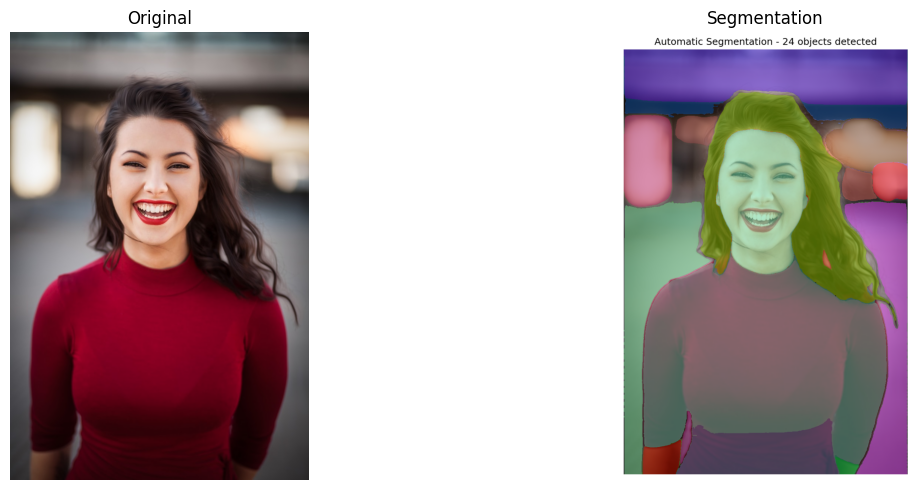


TEST 2: HARD CASE - Complex edges with hair
   Objects detected: 10
   Inference time: 8.206s
   Note: Hair edges are challenging due to fine detail


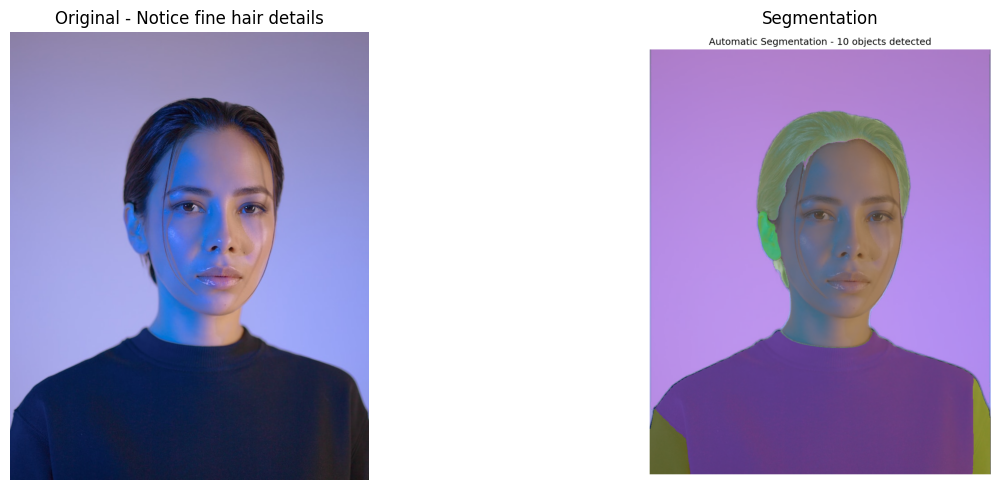


TEST 3: AMBIGUOUS CASE - Multiple similar objects
   Objects detected: 170
   Inference time: 6.957s
   Challenge: Distinguishing between similar objects


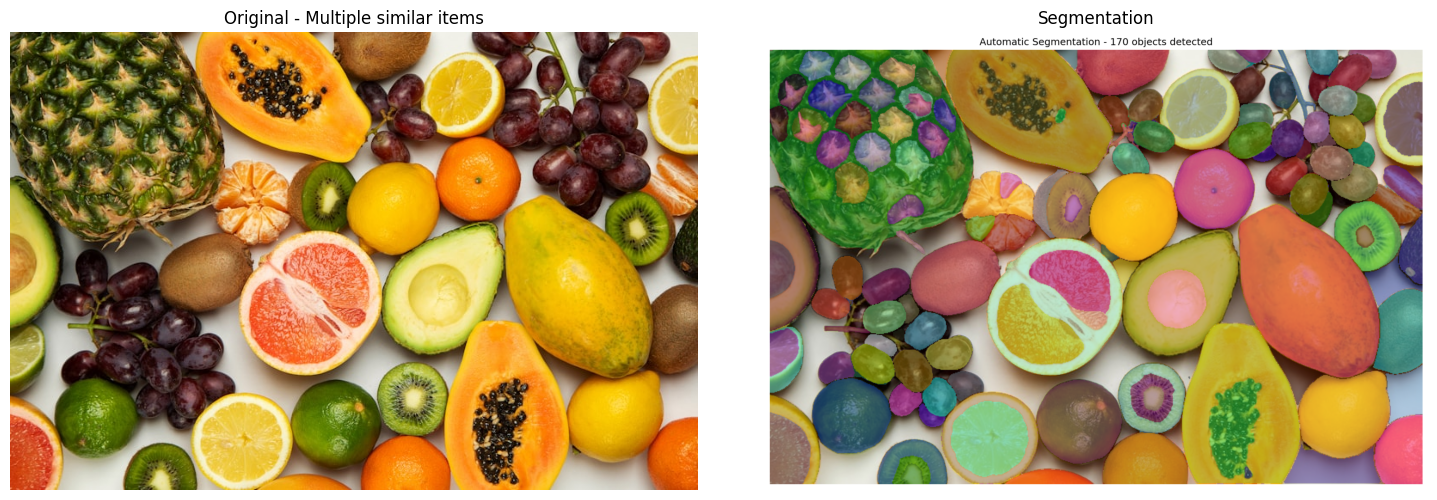


TEST 4: FAILURE CASE - Transparent glass/reflective surfaces
   Objects detected: 9
   Inference time: 7.964s

   FAILURE ANALYSIS:
      - Transparent objects lack clear boundaries
      - Reflections create ambiguous edges
      - SAM relies on visual boundaries, struggles with transparency
      - Light refraction creates false edges


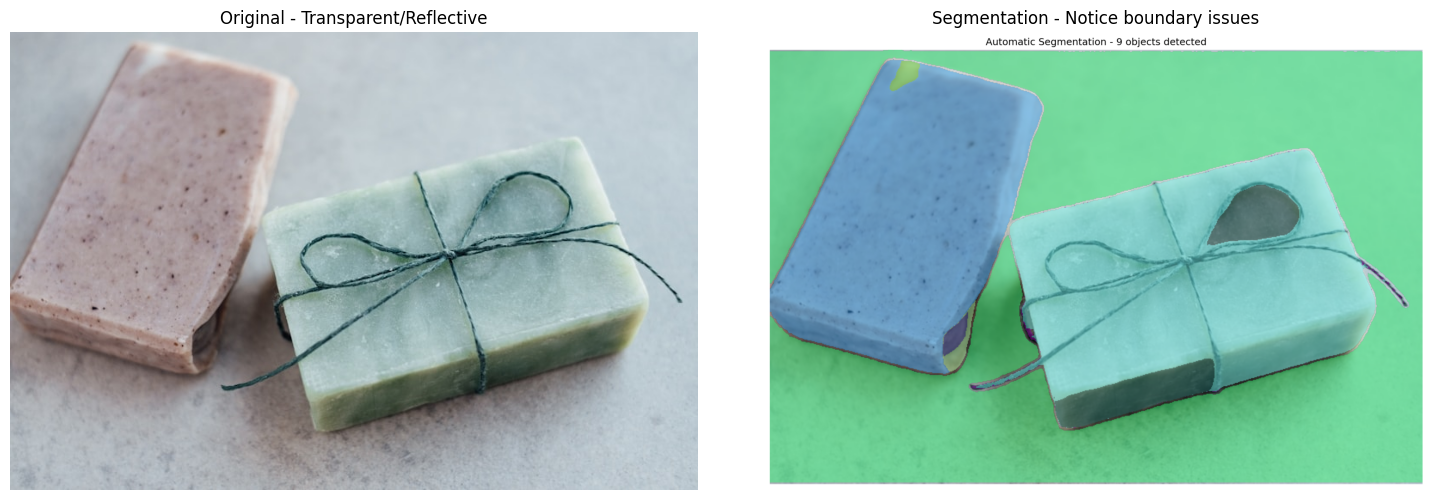


TEST SUMMARY
Easy            | PASSED       | Time: 7.866s
Hard            | PASSED       | Time: 8.206s
Ambiguous       | PASSED       | Time: 6.957s
Failure         | PASSED       | Time: 7.964s


In [13]:
# TEST CASES - 4 SCENARIOS

def run_test_cases():
    """Run all 4 required test cases"""

    print("\n" + "="*80)
    print("RUNNING TEST CASES")
    print("="*80)

    test_results = []

    # Test 1: Easy case - Clear foreground/background
    print("\nTEST 1: EASY CASE - Clear portrait on simple background")
    try:
        img = cv2.imread('test_images/easy_portrait.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        vis, masks, stats = segmenter.segment_automatic(img)

        print(f"   Objects detected: {stats['num_objects']}")
        print(f"   Inference time: {stats['inference_time']:.3f}s")

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title('Original')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(vis)
        plt.title('Segmentation')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

        test_results.append(('Easy', True, stats['inference_time']))
    except Exception as e:
        print(f"   Failed: {e}")
        test_results.append(('Easy', False, 0))

    # Test 2: Hard case - Complex edges (hair)
    print("\nTEST 2: HARD CASE - Complex edges with hair")
    try:
        img = cv2.imread('test_images/complex_hair.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        vis, masks, stats = segmenter.segment_automatic(img)

        print(f"   Objects detected: {stats['num_objects']}")
        print(f"   Inference time: {stats['inference_time']:.3f}s")
        print(f"   Note: Hair edges are challenging due to fine detail")

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title('Original - Notice fine hair details')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(vis)
        plt.title('Segmentation')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

        test_results.append(('Hard', True, stats['inference_time']))
    except Exception as e:
        print(f"   Failed: {e}")
        test_results.append(('Hard', False, 0))

    # Test 3: Ambiguous case - Multiple similar objects
    print("\nTEST 3: AMBIGUOUS CASE - Multiple similar objects")
    try:
        img = cv2.imread('test_images/multiple_objects.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        vis, masks, stats = segmenter.segment_automatic(img)

        print(f"   Objects detected: {stats['num_objects']}")
        print(f"   Inference time: {stats['inference_time']:.3f}s")
        print(f"   Challenge: Distinguishing between similar objects")

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title('Original - Multiple similar items')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(vis)
        plt.title('Segmentation')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

        test_results.append(('Ambiguous', True, stats['inference_time']))
    except Exception as e:
        print(f"   Failed: {e}")
        test_results.append(('Ambiguous', False, 0))

    # Test 4: Failure case - Transparent/reflective objects
    print("\nTEST 4: FAILURE CASE - Transparent glass/reflective surfaces")
    try:
        img = cv2.imread('test_images/transparent_glass.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        vis, masks, stats = segmenter.segment_automatic(img)

        print(f"   Objects detected: {stats['num_objects']}")
        print(f"   Inference time: {stats['inference_time']:.3f}s")
        print(f"\n   FAILURE ANALYSIS:")
        print(f"      - Transparent objects lack clear boundaries")
        print(f"      - Reflections create ambiguous edges")
        print(f"      - SAM relies on visual boundaries, struggles with transparency")
        print(f"      - Light refraction creates false edges")

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title('Original - Transparent/Reflective')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(vis)
        plt.title('Segmentation - Notice boundary issues')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

        test_results.append(('Failure', True, stats['inference_time']))
    except Exception as e:
        print(f"   Failed: {e}")
        test_results.append(('Failure', False, 0))

    # Summary
    print("\n" + "="*80)
    print("TEST SUMMARY")
    print("="*80)
    for test_name, success, time_taken in test_results:
        status = "PASSED" if success else "FAILED"
        print(f"{test_name:15} | {status:12} | Time: {time_taken:.3f}s")

    return test_results

# Run all test cases
print("\nRunning comprehensive test cases...")
test_results = run_test_cases()

In [20]:
print("Launching SAM Image Segmentation Tool...")
print("This may take a few seconds...")
print("A public URL will be generated that anyone can access!")

# Create and launch the interface
demo = create_interface()

# Launch with public sharing
demo.launch(
    share=True,
    debug=False,
    server_name="0.0.0.0",
    server_port=7861
)



Launching SAM Image Segmentation Tool...
This may take a few seconds...
A public URL will be generated that anyone can access!
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fed69e4723086205a9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
